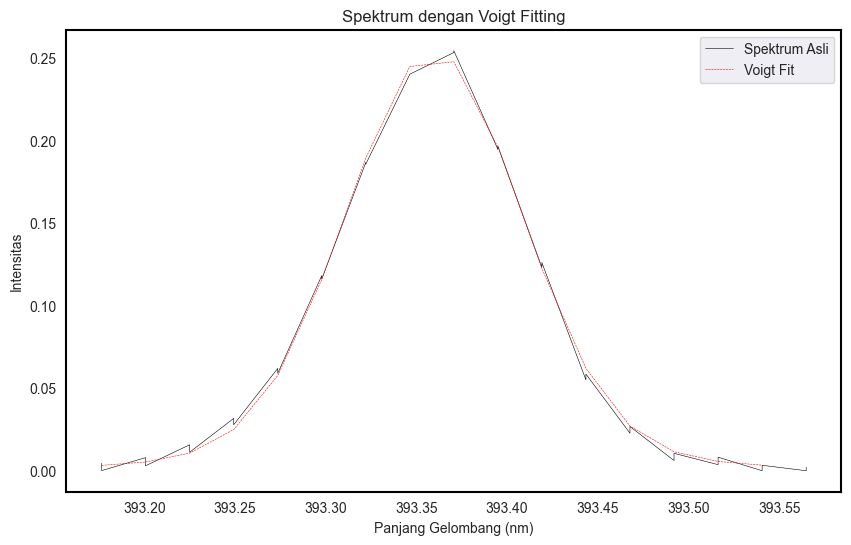

Hasil fitting Voigt: Amplitudo = 0.0331269892490031, Pusat = 393.3596 nm, Sigma (Gaussian) = 0.0456, Gamma (Lorentzian) = 0.0078
FWHM Voigt: 0.1160 nm
Densitas elektron: 3.24e+17 cm^-3


In [8]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

def voigt_profile(x, amp, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

def calculate_voigt_fwhm(sigma, gamma):
    fwhm = 0.5346 * (2 * gamma) + np.sqrt(0.2166 * (2 * gamma)**2 + (2.355 * sigma)**2)
    return fwhm

def calculate_plasma_density(fwhm_stark, stark_broadening_parameter):
    if stark_broadening_parameter == 0:
        return None
    electron_density = ((fwhm_stark / (2 * stark_broadening_parameter)) ** (3/2)) * 10**17
    return electron_density

def voigt_fitting_with_fwhm_and_density(db_processed, sample_name, line_wavelength, stark_broadening_parameter):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
    """
    search_width = 0.2
    cursor.execute(query, (sample_name, line_wavelength - search_width, line_wavelength + search_width))
    data = cursor.fetchall()
    conn.close()

    if not data:
        return None

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)

    # Finding the region of minimum intensity around the peak for better background selection
    peak_idx = np.argmax(intensities)
    baseline_left_idx = np.argmin(intensities[:peak_idx])  # Left side baseline
    baseline_right_idx = np.argmin(intensities[peak_idx:]) + peak_idx  # Right side baseline

    # Limit the fitting to the true peak region bounded by baseline minimum points
    wavelengths_fit = wavelengths[baseline_left_idx:baseline_right_idx + 1]
    intensities_fit = intensities[baseline_left_idx:baseline_right_idx + 1]
    corrected_intensities = intensities_fit - np.min(intensities_fit)

    # Initial guess for Voigt parameters
    initial_guess = [np.max(corrected_intensities), line_wavelength, 0.1, 0.1]

    try:
        popt, _ = curve_fit(voigt_profile, wavelengths_fit, corrected_intensities, p0=initial_guess)
    except RuntimeError:
        return None

    plot_spectrum_with_fitting(wavelengths, intensities, wavelengths_fit, corrected_intensities, popt)

    amp, center, sigma, gamma = popt
    fwhm_voigt = calculate_voigt_fwhm(sigma, gamma)
    electron_density = calculate_plasma_density(fwhm_voigt, stark_broadening_parameter)

    print(f"Hasil fitting Voigt: Amplitudo = {amp}, Pusat = {center:.4f} nm, Sigma (Gaussian) = {sigma:.4f}, Gamma (Lorentzian) = {gamma:.4f}")
    print(f"FWHM Voigt: {fwhm_voigt:.4f} nm")
    print(f"Densitas elektron: {electron_density:.2e} cm^-3")

    return popt, fwhm_voigt, electron_density

def plot_spectrum_with_fitting(wavelengths, intensities, wavelengths_fit, corrected_intensities, popt):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Mengatur transparansi background
    fig.patch.set_alpha(0)  # Background figure transparan
    ax.set_facecolor((1, 1, 1, 0))  # Background axis transparan
    ax.grid(False)  # Menghapus grid
    
    # Plot spektrum asli dan hasil Voigt fitting
    ax.plot(wavelengths, intensities, label='Spektrum Asli', color='black', linewidth=0.4)
    ax.plot(wavelengths_fit, voigt_profile(wavelengths_fit, *popt), 'r--', label='Voigt Fit', linewidth=0.4)

    # Set warna dan ketebalan border
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    ax.set_title('Spektrum dengan Voigt Fitting')
    ax.set_xlabel('Panjang Gelombang (nm)')
    ax.set_ylabel('Intensitas')
    ax.legend()

    plt.show()

# Database and parameters
db_processed = 'processed_spectra.db'
sample_name = 'S2'
line_wavelength = 393.37061
stark_broadening_parameter = 0.53 / 20

voigt_params, fwhm_voigt, electron_density = voigt_fitting_with_fwhm_and_density(
    db_processed, sample_name, line_wavelength, stark_broadening_parameter
)

In [68]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tkinter import Tk, Button, Label, filedialog, StringVar, OptionMenu, messagebox, ttk, Frame
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import find_peaks

k_B = 8.617333262145e-5

def get_ek_from_nist(db_nist, nist_wavelength):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    query = """
        SELECT "Ek(cm-1)"
        FROM spectrum_data
        WHERE "obs_wl_air(nm)" = ?
    """
    cursor.execute(query, (nist_wavelength,))
    result = cursor.fetchone()
    conn.close()
    
    # Check if result exists and is a valid, non-empty string or float/int
    if result and isinstance(result[0], (int, float, str)) and result[0] not in ["", "[]"]:
        try:
            return float(result[0]) / 8065.544  # Convert from cm-1 to eV
        except ValueError:
            print(f"Skipping invalid Ek value for wavelength {nist_wavelength}")
            return None
    else:
        print(f"No valid Ek data for wavelength {nist_wavelength}")
        return None

def load_data_from_excel(file_path, db_nist, selected_element, selected_ion_stage):
    df = pd.read_excel(file_path)
    required_columns = ["Element", "Ion Stage", "NIST WL", "Exp Peak WL"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    filtered_data = df[(df["Element"] == selected_element) & (df["Ion Stage"] == selected_ion_stage)]
    nist_wavelengths = filtered_data["NIST WL"].tolist()
    exp_wavelengths = filtered_data["Exp Peak WL"].tolist()
    ek_values = [get_ek_from_nist(db_nist, wl) for wl in nist_wavelengths]
    
    data = []
    for nist_wl, exp_wl, ek in zip(nist_wavelengths, exp_wavelengths, ek_values):
        ek_display = f"{ek:.4f} eV" if ek is not None else "N/A"
        data.append((nist_wl, exp_wl, ek_display))
    return data

def get_nist_data_for_wavelengths(db_nist, nist_wavelengths):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    nist_data = []
    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        if result:
            obs_wl, Ek, gA = result
            try:
                Ek = float(Ek) / 8065.544  # Konversi ke eV
                nist_data.append((obs_wl, Ek, float(gA)))
            except ValueError:
                print(f"Skipping invalid Ek value for wavelength {obs_wl}")
    conn.close()
    return nist_data

def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []

    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.2
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            peak_index, _ = find_peaks(intensities, height=max(intensities) * 0.5)
            if len(peak_index) == 0:
                integrated_intensities.append(None)
                continue

            peak_index = peak_index[0]
            left_min_index = np.argmin(intensities[:peak_index])
            right_min_index = np.argmin(intensities[peak_index:]) + peak_index

            integrated_area = np.trapz(intensities[left_min_index:right_min_index + 1], wavelengths[left_min_index:right_min_index + 1])
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)
    conn.close()
    return integrated_intensities

def calculate_temperature(nist_data, intensities, exp_wavelengths):
    energies = []
    boltzmann_values = []

    for i, (wl_nist, Ek, gA) in enumerate(nist_data):
        intensity = intensities[i]
        if intensity is None or gA == 0:
            continue

        boltzmann_value = np.log((intensity * exp_wavelengths[i]) / gA)
        energies.append(Ek)
        boltzmann_values.append(boltzmann_value)

    if len(boltzmann_values) < 2:
        print("Tidak cukup data untuk menghitung suhu plasma.")
        return None, None, None

    slope, intercept, _, _, _ = linregress(energies, boltzmann_values)
    T_plasma = -1 / (k_B * slope)
    return T_plasma, slope, energies, boltzmann_values

class PlasmaTemperatureApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Plasma Temperature Calculator")
        self.root.geometry("1000x600")  # Initial window size

        # Configure root grid to make it responsive
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)

        self.db_nist = "data1.db"
        self.db_processed = "processed_spectra.db"
        self.excel_file_path = None
        self.excel_data = None
        self.elements = []
        self.ion_stages = {}
        self.selected_element = StringVar()
        self.selected_ion_stage = StringVar()
        self.selected_sample = StringVar()
        self.selected_lines = []

        main_frame = Frame(self.root)
        main_frame.grid(row=0, column=0, sticky="nsew")
        
        # Make main_frame expandable
        main_frame.grid_rowconfigure(0, weight=1)
        main_frame.grid_columnconfigure(1, weight=3)

        self.setup_ui(main_frame)

    def setup_ui(self, frame):
        # Set up the input frame
        input_frame = Frame(frame)
        input_frame.grid(row=0, column=0, padx=10, pady=5, sticky="ns")
        input_frame.grid_rowconfigure(6, weight=1)  # Allows resizing vertically

        load_button = Button(input_frame, text="Load Excel File", command=self.load_excel_file)
        load_button.grid(row=0, column=0, columnspan=2, pady=5, sticky="ew")

        Label(input_frame, text="Select Element:").grid(row=1, column=0, sticky="e")
        self.element_menu = OptionMenu(input_frame, self.selected_element, ())
        self.element_menu.grid(row=1, column=1, sticky="ew", pady=5)

        Label(input_frame, text="Select Ion Stage:").grid(row=2, column=0, sticky="e")
        self.ion_stage_menu = OptionMenu(input_frame, self.selected_ion_stage, ())
        self.ion_stage_menu.grid(row=2, column=1, sticky="ew", pady=5)

        Label(input_frame, text="Select Sample:").grid(row=3, column=0, sticky="e")
        sample_options = [f"S{i}" for i in range(1, 25)]
        self.selected_sample.set(sample_options[0])
        sample_menu = OptionMenu(input_frame, self.selected_sample, *sample_options)
        sample_menu.grid(row=3, column=1, sticky="ew", pady=5)

        show_table_button = Button(input_frame, text="Show Lines for Selection", command=self.show_line_table)
        show_table_button.grid(row=4, column=0, columnspan=2, pady=10, sticky="ew")

        calculate_button = Button(input_frame, text="Calculate Plasma Temperature", command=self.calculate_plasma_temperature)
        calculate_button.grid(row=5, column=0, columnspan=2, pady=10, sticky="ew")

        # Set up the plot frame and make it proportional
        plot_frame = Frame(frame)
        plot_frame.grid(row=0, column=1, padx=10, pady=5, sticky="nsew")
        plot_frame.grid_rowconfigure(0, weight=1)
        plot_frame.grid_columnconfigure(0, weight=1)
        self.plot_frame = plot_frame
        self.canvas = None

        # Set up the table frame and make it proportional
        self.table_frame = Frame(frame)
        self.table_frame.grid(row=1, column=0, padx=10, pady=5, sticky="nsew")
        self.table_frame.grid_rowconfigure(0, weight=1)
        self.table_frame.grid_columnconfigure(0, weight=1)

        # Set up the result frame
        self.result_frame = Frame(frame)
        self.result_frame.grid(row=1, column=1, padx=10, pady=5, sticky="nsew")
        self.result_frame.grid_rowconfigure(0, weight=1)
        self.result_frame.grid_columnconfigure(0, weight=1)

    def load_excel_file(self):
        file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx")])
        if file_path:
            try:
                self.excel_file_path = file_path
                df = pd.read_excel(file_path)
                required_columns = ["Element", "Ion Stage", "NIST WL", "Exp Peak WL"]
                if not all(col in df.columns for col in required_columns):
                    raise ValueError("Excel file is missing required columns.")
                self.excel_data = df
                self.update_element_menu()
                messagebox.showinfo("Success", "Excel data loaded successfully.")
            except Exception as e:
                messagebox.showerror("Error", str(e))

    def update_element_menu(self):
        self.elements = self.excel_data["Element"].unique().tolist()
        self.ion_stages = {
            element: self.excel_data[self.excel_data["Element"] == element]["Ion Stage"].unique().tolist()
            for element in self.elements
        }

        self.element_menu["menu"].delete(0, "end")
        for element in self.elements:
            self.element_menu["menu"].add_command(label=element, command=lambda el=element: self.on_element_selected(el))

        if self.elements:
            self.selected_element.set(self.elements[0])
            self.on_element_selected(self.elements[0])

    def on_element_selected(self, element):
        self.selected_element.set(element)
        self.update_ion_stage_menu(element)

    def update_ion_stage_menu(self, element):
        ion_stages = self.ion_stages.get(element, [])
        self.ion_stage_menu["menu"].delete(0, "end")
        
        for ion_stage in ion_stages:
            self.ion_stage_menu["menu"].add_command(label=ion_stage, command=lambda ion=ion_stage: self.selected_ion_stage.set(ion))
        
        if ion_stages:
            self.selected_ion_stage.set(ion_stages[0])

    def show_line_table(self):
        selected_element = self.selected_element.get()
        selected_ion_stage = int(self.selected_ion_stage.get())

        line_data = load_data_from_excel(self.excel_file_path, self.db_nist, selected_element, selected_ion_stage)
        exp_wavelengths = [row[1] for row in line_data]
        integrated_intensities = get_integrated_intensity_with_min_bounds(self.db_processed, self.selected_sample.get(), exp_wavelengths)

        for widget in self.table_frame.winfo_children():
            widget.destroy()

        tree = ttk.Treeview(self.table_frame, columns=("NIST WL", "Exp WL", "Ek (eV)", "Integrated Intensity"), show="headings", selectmode="extended")
        tree.heading("NIST WL", text="NIST WL")
        tree.heading("Exp WL", text="Exp WL")
        tree.heading("Ek (eV)", text="Ek (eV)")
        tree.heading("Integrated Intensity", text="Integrated Intensity")

        for row, intensity in zip(line_data, integrated_intensities):
            tree.insert("", "end", values=(row[0], row[1], row[2], f"{intensity:.2f}" if intensity else "N/A"))
        
        tree.pack(fill="both", expand=True)
        
        select_button = Button(self.table_frame, text="Select Lines", command=lambda: self.select_lines(tree))
        select_button.pack(pady=5)

    def select_lines(self, tree):
        selected_items = tree.selection()
        self.selected_lines = [(tree.item(item)["values"][0], tree.item(item)["values"][1]) for item in selected_items]
        messagebox.showinfo("Selection", f"{len(self.selected_lines)} lines selected for temperature calculation.")

    def calculate_plasma_temperature(self):
        if not self.selected_lines:
            messagebox.showerror("Error", "No lines selected for calculation.")
            return

        nist_wavelengths = [float(line[0]) for line in self.selected_lines]
        exp_wavelengths = [float(line[1]) for line in self.selected_lines]

        intensities = get_integrated_intensity_with_min_bounds(self.db_processed, self.selected_sample.get(), exp_wavelengths)
        nist_data = get_nist_data_for_wavelengths(self.db_nist, nist_wavelengths)

        T_plasma, slope, energies, boltzmann_values = calculate_temperature(nist_data, intensities, exp_wavelengths)
        
        if T_plasma:
            messagebox.showinfo("Result", f"Suhu plasma: {T_plasma:.2f} K")
            self.plot_boltzmann_plot(energies, boltzmann_values, slope)
            self.display_results(T_plasma, slope)
            self.export_results(T_plasma, slope, nist_wavelengths, exp_wavelengths, intensities)

    def plot_boltzmann_plot(self, energies, boltzmann_values, slope):
        if self.canvas:
            self.canvas.get_tk_widget().pack_forget()
    
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Set transparansi background
        fig.patch.set_alpha(0)  # Background figure transparan
        ax.set_facecolor((1, 1, 1, 0))  # Background axis transparan
        ax.grid(False)  # Menghapus grid
        
        # Plot data points and fit line
        intercept = boltzmann_values[0] - slope * energies[0]
        ax.scatter(energies, boltzmann_values, color='red', s=10, label="Data Points")  # Titik berwarna merah
        ax.plot(energies, slope * np.array(energies) + intercept, color='black', linewidth=0.4, label=f'Fit Line (Slope = {slope:.3f})')  # Garis plot hitam dengan ketebalan 0.4
        
        # Set warna dan ketebalan border
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
        
        ax.set_xlabel('Excitation Energy (eV)')
        ax.set_ylabel('ln(I * λ / gA)')
        ax.set_title('Boltzmann Plot')
        ax.legend()
        
        # Render plot to Tkinter canvas
        self.canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack()
        
        # Save plot as PDF with transparency
        fig.savefig(f"{self.selected_sample.get()}_BoltzmannPlot.pdf", format="pdf", transparent=True)


    def display_results(self, T_plasma, slope):
        for widget in self.result_frame.winfo_children():
            widget.destroy()

        result_table = ttk.Treeview(self.result_frame, columns=("Slope", "Temperature (K)"), show="headings")
        result_table.heading("Slope", text="Slope")
        result_table.heading("Temperature (K)", text="Temperature (K)")
        result_table.insert("", "end", values=(f"{slope:.3f}", f"{T_plasma:.2f}"))
        result_table.pack(fill="both", expand=True)

    def export_results(self, T_plasma, slope, nist_wavelengths, exp_wavelengths, intensities):
        # Mendapatkan data tambahan untuk ekspor
        nist_data = get_nist_data_for_wavelengths(self.db_nist, nist_wavelengths)
        energies = []
        boltzmann_values = []
    
        for i, (wl_nist, Ek, gA) in enumerate(nist_data):
            intensity = intensities[i]
            if intensity is not None and gA != 0:
                boltzmann_value = np.log((intensity * exp_wavelengths[i]) / gA)
                energies.append(Ek)
                boltzmann_values.append(boltzmann_value)
            else:
                energies.append(None)
                boltzmann_values.append(None)
    
        # Menyiapkan data untuk diekspor dalam bentuk DataFrame
        data = {
            "Element": [self.selected_element.get()] * len(nist_wavelengths),
            "Ion Stage": [self.selected_ion_stage.get()] * len(nist_wavelengths),
            "NIST WL": nist_wavelengths,
            "Exp WL": exp_wavelengths,
            "Integrated Intensity": [f"{i:.2f}" if i else "N/A" for i in intensities],
            "Ek (eV)": [f"{get_ek_from_nist(self.db_nist, wl):.4f}" if get_ek_from_nist(self.db_nist, wl) is not None else "N/A" for wl in nist_wavelengths],
            "Einstein Coefficient": [nist_data[i][2] if i < len(nist_data) else "N/A" for i in range(len(nist_wavelengths))],
            "Excitation Energy (eV)": energies,
            "Boltzmann Value": boltzmann_values
        }
    
        # Mengonversi data menjadi DataFrame
        df = pd.DataFrame(data)
    
        # Menambahkan baris terakhir dengan hasil slope dan suhu sebagai DataFrame tambahan
        results_data = {
            "Element": ["Result"],
            "Ion Stage": ["-"],
            "NIST WL": ["-"],
            "Exp WL": ["-"],
            "Integrated Intensity": ["-"],
            "Ek (eV)": ["-"],
            "Einstein Coefficient": ["-"],
            "Excitation Energy (eV)": ["Slope"],
            "Boltzmann Value": [slope]
        }
        results_df = pd.DataFrame(results_data)
        results_df = pd.concat([results_df, pd.DataFrame({"Excitation Energy (eV)": ["Temperature (K)"], "Boltzmann Value": [T_plasma]})], ignore_index=True)
    
    
        # Menggabungkan hasil dengan data utama
        df = pd.concat([df, results_df], ignore_index=True)
    
        # Ekspor DataFrame ke file Excel
        output_filename = f"{self.selected_sample.get()}_T.xlsx"
        df.to_excel(output_filename, index=False)
        messagebox.showinfo("Export", f"Results exported successfully as {output_filename}.")

root = Tk()
app = PlasmaTemperatureApp(root)
root.mainloop()

2024-11-14 02:52:29.337 Python[65790:2593006] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-14 02:52:29.338 Python[65790:2593006] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2024-11-14 02:52:32.875 Python[65790:2593006] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


No valid Ek data for wavelength 396.152
No valid Ek data for wavelength 396.152
No valid Ek data for wavelength 237.207
No valid Ek data for wavelength 309.271
No valid Ek data for wavelength 394.4006
No valid Ek data for wavelength 396.152


Data tidak ditemukan di database untuk: Element=Al, Ion Stage=1, NIST WL=396.152
  Available data -> Sim Peak WL: 396.1654, Exp WL: 396.1488, Exp Intensity: 0.361713, Einstein Coefficient: 197000000
Data tidak ditemukan di database untuk: Element=C, Ion Stage=1, NIST WL=247.8561
  Available data -> Sim Peak WL: 247.8596, Exp WL: 247.849, Exp Intensity: 0.006125, Einstein Coefficient: 84000000
Data tidak ditemukan di database untuk: Element=Cu, Ion Stage=1, NIST WL=324.754
  Available data -> Sim Peak WL: 324.7558, Exp WL: 324.8565, Exp Intensity: 0.006871, Einstein Coefficient: 558000000
Data tidak ditemukan di database untuk: Element=Eu, Ion Stage=2, NIST WL=390.71
  Available data -> Sim Peak WL: 390.7070219864143, Exp WL: 390.68475, Exp Intensity: 0.0046415231210385, Einstein Coefficient: 685000000
Data tidak ditemukan di database untuk: Element=Fe, Ion Stage=1, NIST WL=381.584
  Available data -> Sim Peak WL: 381.5909, Exp WL: 382.0324, Exp Intensity: 0.058765, Einstein Coefficient

Data tidak lengkap untuk Element=Ba, Ion Stage=2. Lewati perhitungan.
Data energi ionisasi untuk Eu dengan ion_stage 1 tidak ditemukan.
Data energi ionisasi untuk Pb dengan ion_stage 1 tidak ditemukan.
Konsentrasi total unsur dalam sampel (dalam persen):
Ag: 1.65%
Al: 7.91%
As: 0.01%
Br: 0.26%
C: 1.20%
Ca: 0.04%
Cl: 0.16%
Cu: 0.51%
Eu: 0.00%
Fe: 47.53%
Ga: 0.29%
H: 8.60%
K: 9.54%
Li: 4.27%
Mg: 0.23%
Mn: 0.00%
N: 0.40%
Na: 9.27%
Nd: 0.04%
O: 5.38%
P: 0.00%
Pb: 0.00%
Rb: 2.19%
Si: 0.01%
Sr: 0.05%
Ti: 0.08%
V: 0.02%
Y: 0.08%
Zn: 0.27%


In [11]:
import pandas as pd

# Fungsi untuk memuat data ionisasi dari CSV dan menyimpan data energi ionisasi ke Excel
def save_ionization_energy_to_excel_with_converted_ion_stage(csv_path, output_excel_path):
    # Load ionization data dari iona.csv
    ionization_data = pd.read_csv(csv_path)
    
    # Bersihkan data, hapus tanda kutip dan '=' di sekitar nilai
    ionization_data = ionization_data.apply(lambda col: col.map(lambda x: x.replace('"', '').strip('=') if isinstance(x, str) else x))
    
    # Ambil kolom yang relevan: elemen, ion charge, dan energi ionisasi
    ionization_energy_data = ionization_data[['Isoel. Seq.', 'Ion Charge', 'Ionization Energy (eV)']]
    
    # Ubah nama kolom dan konversi Ion Charge ke Ion Stage
    ionization_energy_data.columns = ['Element', 'Ion Charge', 'Ionization Energy (eV)']
    ionization_energy_data['Ion Stage'] = ionization_energy_data['Ion Charge'].apply(lambda x: 1 if x == '0' else 2 if x == '+1' else None)
    
    # Hapus kolom Ion Charge karena sudah digantikan dengan Ion Stage
    ionization_energy_data = ionization_energy_data[['Element', 'Ion Stage', 'Ionization Energy (eV)']]
    
    # Simpan data ke file Excel baru
    ionization_energy_data.to_excel(output_excel_path, index=False)
    print(f"Data energi ionisasi telah disimpan di {output_excel_path}")

# Path ke file CSV dan output file Excel
csv_path = "iona.csv"
output_excel_path = "ionization_energy_converted.xlsx"

# Jalankan fungsi untuk menyimpan data energi ionisasi ke Excel
save_ionization_energy_to_excel_with_converted_ion_stage(csv_path, output_excel_path)

Data energi ionisasi telah disimpan di ionization_energy_converted.xlsx


/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_24134/1288792151.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ionization_energy_data['Ion Stage'] = ionization_energy_data['Ion Charge'].apply(lambda x: 1 if x == '0' else 2 if x == '+1' else None)


In [1]:
import pandas as pd

# Path ke file Excel Anda
excel_path = "S1.xlsx"  # Ganti dengan path yang sesuai jika berbeda

# Muat data dari Excel
df = pd.read_excel(excel_path)

# Cari baris yang memiliki duplikat di kolom 'NIST WL' dan ambil salah satu dari setiap grup duplikat
duplicates_one = df[df.duplicated(subset='NIST WL', keep='first')]

# Hapus salah satu dari setiap grup duplikat dari sheet asal
df_cleaned = df.drop(duplicates_one.index)

# Tulis hasil ke dalam file Excel baru, dengan sheet asal yang telah dibersihkan dan sheet "Duplicates" untuk duplikat
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    df_cleaned.to_excel(writer, sheet_name="Sheet3", index=False)  # Ganti "Sheet1" dengan nama sheet asal jika berbeda
    duplicates_one.to_excel(writer, sheet_name="Duplicates1", index=False)
    
print("Salah satu baris dari setiap pasangan duplikat telah dipindahkan ke sheet 'Duplicates' dan dihapus dari sheet asal.")

Salah satu baris dari setiap pasangan duplikat telah dipindahkan ke sheet 'Duplicates' dan dihapus dari sheet asal.


In [8]:
import numpy as np
import pandas as pd
import sqlite3

k_B = 8.617333262145e-5
m_e = 9.10938356e-31
h = 6.62607015e-34

def load_ionization_data(excel_path):
    ionization_data = pd.read_excel(excel_path)
    return ionization_data

ionization_energy_cache = {}

def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan di file ionization_energy_converted.xlsx.")
        ionization_energy_cache[key] = None
        return None

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent

def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []

    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.1
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities = zip(*results)
            intensities = np.array(intensities)
            if len(intensities) == 0 or np.all(intensities == 0):
                integrated_intensities.append(None)
                continue

            peak_index = np.argmax(intensities)
            left_min_index = np.argmin(intensities[:peak_index]) if peak_index > 0 else 0
            right_min_index = np.argmin(intensities[peak_index:]) + peak_index if peak_index < len(intensities) - 1 else len(intensities) - 1

            integrated_area = np.trapz(intensities[left_min_index:right_min_index + 1], wavelengths[left_min_index:right_min_index + 1])
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)

    conn.close()
    return integrated_intensities

def load_spectral_data_from_excel(s1_a_path, db_processed, sample_name):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "NIST WL", "Einstein Coefficient", "Exp Peak WL", "Exp Intensity", "gi", "gk", "Ei (cm-1)", "Ek (cm-1)"]
    df = pd.read_excel(s1_a_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    exp_wavelengths = df["Exp Peak WL"].tolist()
    intensities = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths)

    spectral_data = []
    for (_, row), intensity in zip(df.iterrows(), intensities):
        element = row["Element"]
        ion_stage = row["Ion Stage"]
        exp_wl = row["Exp Peak WL"]
        gA = row["Einstein Coefficient"]
        gi = row["gi"]
        gk = row["gk"]
        Ei = row["Ei (cm-1)"]
        Ek = row["Ek (cm-1)"]
        Ek_in_eV = Ek / 8065.544 if Ek else None

        data_entry = {
            "Element": element,
            "Ion Stage": ion_stage,
            "Exp WL": exp_wl,
            "Intensity": intensity,  # Use integrated intensity
            "Einstein Coefficient": gA,
            "gi": gi,
            "gk": gk,
            "Ei (cm-1)": Ei,
            "Ek (eV)": Ek_in_eV
        }

        spectral_data.append(data_entry)
    
    return spectral_data

def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []

    for data in spectral_data:
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Intensity"]
        wl = data["Exp WL"]
        E_u = data.get("Ek (eV)")
        Aki = data.get("Einstein Coefficient")

        if E_u is None or Aki is None:
            print(f"Data tidak lengkap untuk Element={element}, Ion Stage={ion_stage}. Lewati perhitungan.")
            continue

        Z_neutral = np.exp(-E_u / (k_B * T_e))
        N_rel = (intensity * wl) / (Aki * np.exp(-E_u / (k_B * T_e))) if Aki else 0
        neutral_concentration = N_rel

        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            Z_ion = np.exp(-E_u / (k_B * T_e))
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * neutral_concentration
            total_concentration = neutral_concentration + ion_concentration
        else:
            total_concentration = neutral_concentration

        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration

        overall_concentration += total_concentration

        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "Exp WL": wl,
            "Intensity": intensity,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration  # Simpan nilai awal
        })

    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100

    # Perbarui Total Concentration di detailed_data menjadi persen
    for row in detailed_data:
        element = row["Element"]
        row["Total Concentration"] = (row["Total Concentration"] / overall_concentration) * 100

    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data.xlsx", index=False)

    return total_concentrations

# Load data
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")
s1_a_path = 'S1_a.xlsx'
db_processed = 'processed_spectra.db'
sample_name = 'S1'

spectral_data = load_spectral_data_from_excel(s1_a_path, db_processed, sample_name)

# Calculate concentrations
T_e = 11963.46126
n_e = 2.73e+17
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

# Display results
print("Konsentrasi total unsur dalam sampel (dalam persen):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.20f}%")

Konsentrasi total unsur dalam sampel (dalam persen):
Ag: nan%
Al: nan%
Ba: nan%
C: nan%
Ca: nan%
Cu: nan%
Fe: nan%
H: nan%
K: nan%
Li: nan%
Mg: nan%
Mn: nan%
N: nan%
Nd: nan%
O: nan%
Si: nan%
Sr: nan%
Ti: nan%
V: nan%
Na: nan%


In [4]:
import sqlite3
import pandas as pd

def export_data_for_sp_num_to_excel(db_path, sp_nums, output_file):
    """
    Export data for specific sp_num values (e.g., 1 and 2) from data1.db to an Excel file.
    """
    conn = sqlite3.connect(db_path)
    
    # Create the SQL query with placeholders for sp_num values
    query = f"""
        SELECT *
        FROM spectrum_data
        WHERE sp_num IN ({','.join(['?'] * len(sp_nums))})
    """
    
    # Execute the query with sp_num parameters
    df = pd.read_sql_query(query, conn, params=sp_nums)
    conn.close()
    
    if df.empty:
        print(f"No data found for sp_num values: {sp_nums}")
    else:
        # Export data to Excel
        df.to_excel(output_file, index=False)
        print(f"Data has been exported to {output_file}")

# Replace 'data1.db' with the path to your database and specify the desired output file name
db_path = 'data1.db'
output_file = 'sp_num_1_and_2_data.xlsx'

# sp_num values for filtering
sp_nums = [1, 2]

# Run the function to export data
export_data_for_sp_num_to_excel(db_path, sp_nums, output_file)

Data has been exported to sp_num_1_and_2_data.xlsx


In [1]:
import pandas as pd
import sqlite3

def excel_to_sqlite(excel_path, db_path, table_name="a"):
    """
    Convert an Excel file to a SQLite database.
    
    Parameters:
    - excel_path: Path to the input Excel file (e.g., "data1.xlsx")
    - db_path: Path to the output SQLite database (e.g., "data1.db")
    - table_name: Name of the table to create in the database
    """
    # Load data from Excel
    df = pd.read_excel(excel_path)
    
    # Connect to SQLite database (it will create a new one if it doesn't exist)
    conn = sqlite3.connect(db_path)
    
    # Write the DataFrame to a SQL table in the SQLite database
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Close the connection
    conn.close()
    print(f"Data from {excel_path} has been saved to {db_path} as table '{table_name}'.")

# Specify paths for the Excel file and output database
excel_path = "data1.xlsx"      # Path to your Excel file
db_path = "data2.db"       # Path for the new SQLite database

# Run the function to convert Excel to SQLite
excel_to_sqlite(excel_path, db_path)

Data from data1.xlsx has been saved to data2.db as table 'a'.


In [1]:
import pandas as pd

# Load the Excel file
excel_path = "data1.xlsx"  # Replace with your Excel file path
df = pd.read_excel(excel_path)

# Convert columns to string for accurate comparison
df['NIST WL'] = df['NIST WL'].astype(str)
df['obs_wl_air(nm)'] = df['obs_wl_air(nm)'].astype(str)

# Check and copy values if 'NIST WL' is equal to 'obs_wl_air(nm)'
for index, row in df.iterrows():
    if row['NIST WL'] == row['obs_wl_air(nm)']:
        # Copy values from source columns to target columns
        df.at[index, 'gi'] = row['g_i']
        df.at[index, 'gk'] = row['g_k']
        df.at[index, 'Ei'] = row['Ei(cm-1)']
        df.at[index, 'Ek'] = row['Ek(cm-1)']

# Save the updated DataFrame to a new Excel file
output_path = "updated_S11.xlsx"
df.to_excel(output_path, index=False)
print(f"Data has been saved to {output_path}")

Data has been saved to updated_S11.xlsx


In [65]:
import pandas as pd
import sqlite3

def fetch_additional_data(db_path, nist_wavelength, tolerance=0.001):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Query untuk mengambil data dalam rentang toleransi
    query = """
        SELECT g_i, g_k, "Ei(cm-1)", "Ek(cm-1)"
        FROM spectrum_data
        WHERE ABS("obs_wl_air(nm)" - ?) < ?
    """
    cursor.execute(query, (nist_wavelength, tolerance))
    result = cursor.fetchone()
    conn.close()
    
    if result:
        g_i, g_k, Ei_cm1, Ek_cm1 = result
        
        # Bersihkan tanda kurung jika ada, dan konversi ke float
        try:
            Ei = float(str(Ei_cm1).strip('[]')) * 0.000123984 if Ei_cm1 not in (None, '') else None
            Ek = float(str(Ek_cm1).strip('[]')) * 0.000123984 if Ek_cm1 not in (None, '') else None
        except ValueError:
            Ei, Ek = None, None  # Set None jika konversi gagal

        return g_i, g_k, Ei, Ek
    else:
        return None, None, None, None

def complete_excel_with_db_data(excel_path, db_path, output_path):
    df = pd.read_excel(excel_path)

    # Tambahkan kolom baru untuk gi, gk, Ei, dan Ek
    df['gi'] = None
    df['gk'] = None
    df['Ei (eV)'] = None
    df['Ek (eV)'] = None

    # Iterasi pada setiap baris dan perbarui data berdasarkan NIST WL
    for index, row in df.iterrows():
        nist_wl = row['NIST WL']
        
        if pd.notna(nist_wl):
            gi, gk, Ei, Ek = fetch_additional_data(db_path, nist_wl)
            df.at[index, 'gi'] = gi
            df.at[index, 'gk'] = gk
            df.at[index, 'Ei (eV)'] = Ei
            df.at[index, 'Ek (eV)'] = Ek

    # Simpan DataFrame hasil ke file Excel baru
    df.to_excel(output_path, index=False)
    print(f"Data lengkap telah disimpan ke {output_path}")

# Jalankan fungsi dengan path ke file Excel, database, dan output file
excel_path = 'S1.xlsx'  # Ganti dengan path ke file Excel Anda
db_path = 'data1.db'  # Ganti dengan path ke database Anda
output_path = 'completed_data.xlsx'  # Ganti dengan path output yang diinginkan

complete_excel_with_db_data(excel_path, db_path, output_path)

Data lengkap telah disimpan ke completed_data.xlsx


In [66]:
import numpy as np
import pandas as pd
import sqlite3

# Constants
k_B = 8.617333262145e-5  # eV/K
m_e = 9.10938356e-31  # kg
h = 6.62607015e-34  # J*s

def load_ionization_data(excel_path):
    return pd.read_excel(excel_path)

ionization_energy_cache = {}

def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan.")
        ionization_energy_cache[key] = None
        return None

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent
def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []
    
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.1  # Sesuaikan berdasarkan resolusi spektrometer
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()
    
        if results:
            wavelengths, intensities = zip(*results)
            wavelengths = np.array(wavelengths)
            intensities = np.array(intensities)
            
            # Mengurangi latar belakang
            background = np.min(intensities)
            intensities -= background
            
            # Integrasi menggunakan metode trapezoidal
            integrated_area = np.trapz(intensities, wavelengths)
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)
    
    conn.close()
    return integrated_intensities
def identify_non_overlapping_lines(df, min_separation=0.1):
    df = df.reset_index(drop=True)
    non_overlapping_indices = []
    wavelengths = df["Exp Peak WL"].values
    elements = df["Element"].values
    
    for i in range(len(df)):
        wl_i = wavelengths[i]
        element_i = elements[i]
        overlapping = False
        for j in range(len(df)):
            if i != j:
                wl_j = wavelengths[j]
                element_j = elements[j]
                if abs(wl_i - wl_j) < min_separation and element_i != element_j:
                    overlapping = True
                    break
        if not overlapping:
            non_overlapping_indices.append(i)
    
    df_non_overlapping = df.iloc[non_overlapping_indices]
    return df_non_overlapping
def load_spectral_data_from_excel(excel_path, db_processed, sample_name):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "NIST WL", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity", "gi", "gk", "Ei (eV)", "Ek (eV)"]
    df = pd.read_excel(excel_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    # Hitung intensitas terintegrasi
    exp_wavelengths = df["Exp Peak WL"].tolist()
    df["Integrated Intensity"] = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths)
    
    # Prioritaskan garis dengan intensitas simulasi tertinggi
    df_sorted = df.sort_values(by=["Element", "Sim Peak WL"], ascending=[True, False])
    
    # Identifikasi garis yang tidak tumpang tindih
    df_non_overlapping = identify_non_overlapping_lines(df_sorted)
    
    # Pilih garis pertama per elemen (dengan intensitas simulasi tertinggi dan tidak tumpang tindih)
    df_selected = df_non_overlapping.groupby("Element").first().reset_index()
    
    return df_selected

def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []
    
    for _, data in spectral_data.iterrows():
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Integrated Intensity"]
        wl = data["Exp Peak WL"]
        E_u = data["Ek (eV)"]
        Aki = data["Einstein Coefficient"]
        gi = data["gi"]  # Bobot statistik level bawah
        gk = data["gk"]  # Bobot statistik level atas
        E_l = data["Ei (eV)"]  # Energi level bawah
        
        if pd.isna(E_u) or pd.isna(Aki) or pd.isna(gi) or pd.isna(gk) or pd.isna(E_l):
            print(f"Data tidak lengkap untuk Element={element}, Ion Stage={ion_stage}. Lewati perhitungan.")
            continue
        
        # Fungsi partisi (diasumsikan distribusi Boltzmann)
        Z = gi * np.exp(-E_l / (k_B * T_e))
        
        # Populasi relatif level atas
        N_rel = (intensity * wl) / (Aki * gk * np.exp(-E_u / (k_B * T_e)))
        
        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            # Persamaan Saha untuk mendapatkan rasio ionisasi
            Z_neutral = Z  # Fungsi partisi untuk netral
            Z_ion = Z  # Sederhana; dalam praktik, seharusnya dihitung untuk keadaan terionisasi
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * N_rel
            total_concentration = N_rel + ion_concentration
        else:
            total_concentration = N_rel
        
        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration
        
        overall_concentration += total_concentration
        
        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "Exp WL": wl,
            "Intensity": intensity,
            "Ei (eV)": E_l,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "gi": gi,
            "gk": gk,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration
        })
    
    # Normalisasi konsentrasi ke dalam persen
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100
    
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data_selected_lines.xlsx", index=False)
    
    return total_concentrations

# Load ionization data
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")

# Load spectral data with max integrated intensity per element
excel_path = 'S1coba.xlsx'
db_processed = 'processed_spectra.db'
sample_name = 'S1'

spectral_data = load_spectral_data_from_excel(excel_path, db_processed, sample_name)

# Set parameters for calculation
T_e = 11963.46126  # Plasma temperature in Kelvin
n_e = 2.73e+17  # Electron density in cm^-3

# Calculate total concentrations
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

print("Konsentrasi total unsur dalam sampel (dalam persen):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

Konsentrasi total unsur dalam sampel (dalam persen):
Ag: 0.08%
Al: 0.33%
As: 0.16%
Ba: 0.12%
Br: 0.24%
C: 3.88%
Ca: 0.12%
Cl: 0.40%
Cu: 0.00%
Eu: 0.00%
Fe: 4.36%
Ga: 10.06%
K: 28.70%
Li: 16.81%
Mg: 0.00%
Mn: 7.42%
N: 2.21%
Nd: 0.01%
P: 0.06%
Pb: 0.79%
Rb: 1.34%
Si: 21.14%
Sr: 0.91%
Ti: 0.00%
V: 0.00%
Y: 0.01%
Zn: 0.88%


In [67]:
import numpy as np
import pandas as pd
import sqlite3

# Constants
k_B = 8.617333262145e-5  # eV/K
m_e = 9.10938356e-31  # kg
h = 6.62607015e-34  # J*s

def load_ionization_data(excel_path):
    return pd.read_excel(excel_path)

ionization_energy_cache = {}

def get_ionization_energy(element, ion_stage, ionization_data):
    key = (element, ion_stage)
    if key in ionization_energy_cache:
        return ionization_energy_cache[key]
    
    row = ionization_data[(ionization_data['Element'] == element) & (ionization_data['Ion Stage'] == ion_stage)]
    if not row.empty:
        energy = float(row['Ionization Energy (eV)'].values[0])
        ionization_energy_cache[key] = energy
        return energy
    else:
        print(f"Data energi ionisasi untuk {element} dengan ion_stage {ion_stage} tidak ditemukan.")
        ionization_energy_cache[key] = None
        return None

def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent
def get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()
    integrated_intensities = []
    
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        width = 0.1  # Sesuaikan berdasarkan resolusi spektrometer
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()
    
        if results:
            wavelengths, intensities = zip(*results)
            wavelengths = np.array(wavelengths)
            intensities = np.array(intensities)
            
            # Mengurangi latar belakang
            background = np.min(intensities)
            intensities -= background
            
            # Integrasi menggunakan metode trapezoidal
            integrated_area = np.trapz(intensities, wavelengths)
            integrated_intensities.append(integrated_area)
        else:
            integrated_intensities.append(None)
    
    conn.close()
    return integrated_intensities
def identify_non_overlapping_lines(df, min_separation=0.1):
    df = df.reset_index(drop=True)
    non_overlapping_indices = []
    wavelengths = df["Exp Peak WL"].values
    elements = df["Element"].values
    
    for i in range(len(df)):
        wl_i = wavelengths[i]
        element_i = elements[i]
        overlapping = False
        for j in range(len(df)):
            if i != j:
                wl_j = wavelengths[j]
                element_j = elements[j]
                if abs(wl_i - wl_j) < min_separation and element_i != element_j:
                    overlapping = True
                    break
        if not overlapping:
            non_overlapping_indices.append(i)
    
    df_non_overlapping = df.iloc[non_overlapping_indices]
    return df_non_overlapping
def load_spectral_data_from_excel(excel_path, db_processed, sample_name):
    required_columns = ["Element", "Ion Stage", "Sim Peak WL", "NIST WL", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity", "gi", "gk", "Ei (eV)", "Ek (eV)"]
    df = pd.read_excel(excel_path)
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Excel file is missing required columns.")
    
    # Hitung intensitas terintegrasi
    exp_wavelengths = df["Exp Peak WL"].tolist()
    df["Integrated Intensity"] = get_integrated_intensity_with_min_bounds(db_processed, sample_name, exp_wavelengths)
    
    # Prioritaskan garis dengan intensitas simulasi tertinggi
    df_sorted = df.sort_values(by=["Element", "Sim Peak WL"], ascending=[True, False])
    
    # Identifikasi garis yang tidak tumpang tindih
    df_non_overlapping = identify_non_overlapping_lines(df_sorted)
    
    # Pilih garis pertama per elemen (dengan intensitas simulasi tertinggi dan tidak tumpang tindih)
    df_selected = df_non_overlapping.groupby("Element").first().reset_index()
    
    return df_selected

def calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data):
    total_concentrations = {}
    overall_concentration = 0
    detailed_data = []
    
    for _, data in spectral_data.iterrows():
        element = data["Element"]
        ion_stage = data["Ion Stage"]
        intensity = data["Integrated Intensity"]
        wl = data["NIST WL"]  # Use NIST WL instead of Exp Peak WL
        E_u = data["Ek (eV)"]
        Aki = data["Einstein Coefficient"]
        gi = data["gi"]  # Lower-level statistical weight
        gk = data["gk"]  # Upper-level statistical weight
        E_l = data["Ei (eV)"]  # Lower-level energy
        
        # Check for missing data
        if pd.isna(E_u) or pd.isna(Aki) or pd.isna(gi) or pd.isna(gk) or pd.isna(E_l) or pd.isna(wl):
            print(f"Incomplete data for Element={element}, Ion Stage={ion_stage}. Skipping calculation.")
            continue
        
        # Partition function (assuming Boltzmann distribution)
        Z = gi * np.exp(-E_l / (k_B * T_e))
        
        # Relative population of the upper level
        N_rel = (intensity * wl) / (Aki * gk * np.exp(-E_u / (k_B * T_e)))
        
        E_ionization = get_ionization_energy(element, ion_stage, ionization_data)
        if E_ionization is not None:
            # Saha equation to get the ionization ratio
            Z_neutral = Z  # Partition function for neutral state
            Z_ion = Z  # Simplified; in practice, should be calculated for ionized state
            ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization)
            ion_concentration = ionization_ratio * N_rel
            total_concentration = N_rel + ion_concentration
        else:
            total_concentration = N_rel
        
        if element in total_concentrations:
            total_concentrations[element] += total_concentration
        else:
            total_concentrations[element] = total_concentration
        
        overall_concentration += total_concentration
        
        detailed_data.append({
            "Element": element,
            "Ion Stage": ion_stage,
            "NIST WL": wl,
            "Intensity": intensity,
            "Ei (eV)": E_l,
            "Ek (eV)": E_u,
            "Aki": Aki,
            "gi": gi,
            "gk": gk,
            "N_rel": N_rel,
            "E_ionization": E_ionization,
            "Total Concentration": total_concentration
        })
    
    # Normalize concentrations to percentages
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100
    
    detailed_df = pd.DataFrame(detailed_data)
    detailed_df.to_excel("detailed_concentration_data_selected_lines.xlsx", index=False)
    
    return total_concentrations
# Load ionization data
# Load ionization data
ionization_data = load_ionization_data("ionization_energy_converted.xlsx")

# Load spectral data with max integrated intensity per element
excel_path = 'S1coba.xlsx'
db_processed = 'processed_spectra.db'
sample_name = 'S1'

spectral_data = load_spectral_data_from_excel(excel_path, db_processed, sample_name)

# Set parameters for calculation
T_e = 11963.46126  # Plasma temperature in Kelvin
n_e = 2.73e+17  # Electron density in cm^-3

# Calculate total concentrations using NIST wavelengths
final_concentrations = calculate_total_concentration_with_ionization(T_e, n_e, spectral_data, ionization_data)

print("Total element concentrations in the sample (in percent):")
for element, concentration_percent in final_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

Total element concentrations in the sample (in percent):
Ag: 0.08%
Al: 0.33%
As: 0.16%
Ba: 0.12%
Br: 0.24%
C: 3.88%
Ca: 0.12%
Cl: 0.40%
Cu: 0.00%
Eu: 0.00%
Fe: 4.36%
Ga: 10.05%
K: 28.69%
Li: 16.81%
Mg: 0.00%
Mn: 7.42%
N: 2.21%
Nd: 0.01%
P: 0.06%
Pb: 0.79%
Rb: 1.34%
Si: 21.14%
Sr: 0.91%
Ti: 0.00%
V: 0.00%
Y: 0.01%
Zn: 0.88%
